In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Removing all the warnings
import warnings
warnings.filterwarnings('ignore')

# Setting env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

from einops import rearrange

## Task 2

### Question 1

In [2]:
if os.path.exists('cat.jpg'):
    print('cat.jpg exists')

cat.jpg exists


torch.Size([3, 300, 300])


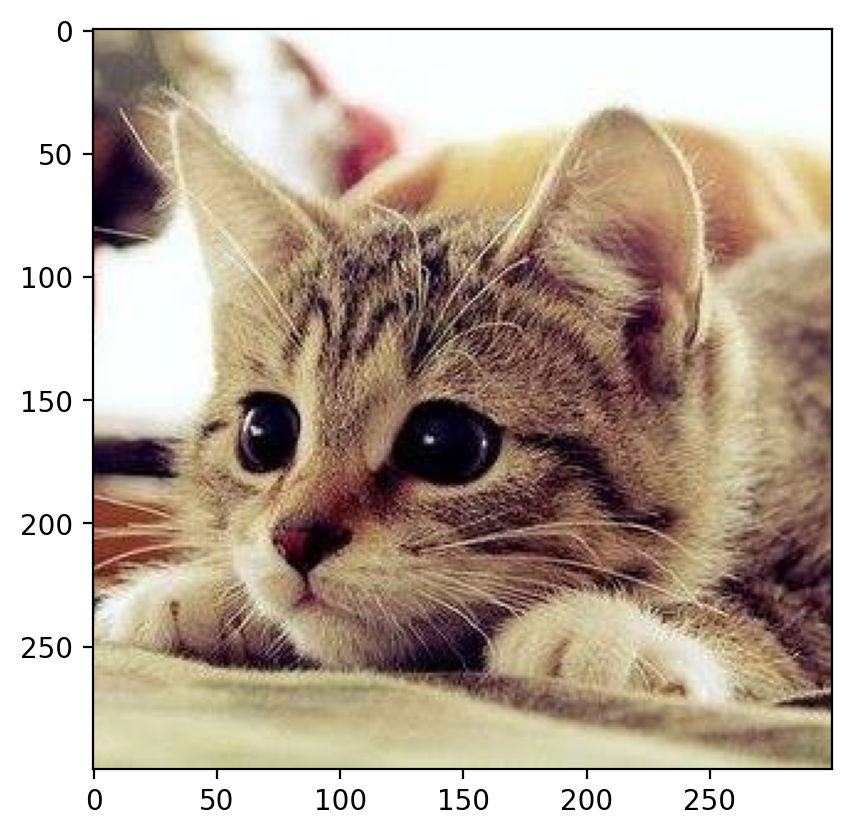

In [3]:
# Read in an image from torchvision
img = torchvision.io.read_image("cat.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1)) # Reshape the image to 2D array
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape) # Scaling and reshaping back to the original image shape
img_scaled = torch.tensor(img_scaled) # Converting image to a PyTorch tensor
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 300, 300])

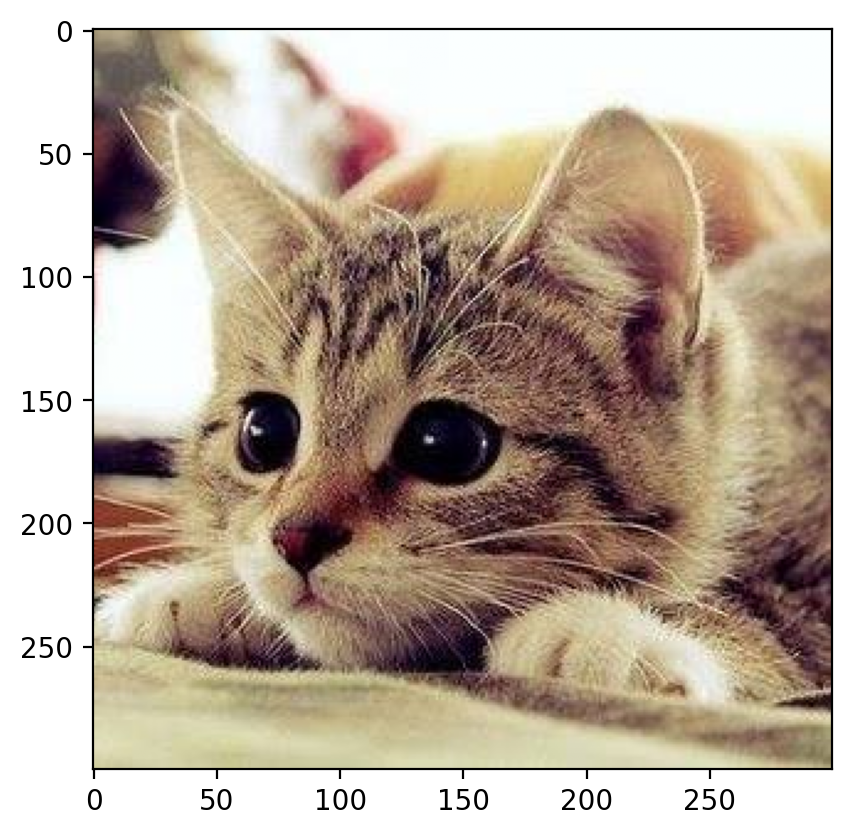

In [5]:
plt.imshow(rearrange(img_scaled, 'c h w -> h w c').cpu().numpy())

In [6]:
crop = img_scaled.to(device) # Copying the image to the device

In [7]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [8]:
img_x, img_y = create_coordinate_map(crop)

img_x.shape, img_y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [9]:
# Initialize the MinMaxScaler to scale between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

# Scaling the X data (scaling is done on CPU)
img_X_scaled = scaler_X.transform(img_x.cpu())

# Converting the scaled data to a PyTorch tensor
img_X_scaled = torch.tensor(img_X_scaled)

# Moving the tensor to the specified device
img_X_scaled = img_X_scaled.to(device)

# Ensuring the data type is float
img_X_scaled = img_X_scaled.float()

#### Linear Regression

In [10]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features) #Linear transformation based on number of input and output features
        
    def forward(self, x): #Forward Pass - linear transformation defined in self.linear
        return self.linear(x)

In [11]:
net = LinearModel(2, 3) #Creating an instance of the LinearModel class with 2 input features and 3 output features
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [12]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float (learning rate)
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    Y: torch.Tensor of shape (num_samples, 3 (R,G,B))
    """

    criterion = nn.MSELoss() #Mean squared error loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    for epoch in range(epochs):
        optimizer.zero_grad() #Initialize to zero

        # Computing the loss
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()

        # Updating the parameters
        optimizer.step()

        # Printing the loss for each epoch (for testing)
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [13]:
# Function to calculate the PSNR (peak signal-to-noise ratio)
def psnr(max_value,mse):
    return  20 * np.log10(max_value/np.sqrt(mse))

In [14]:
mse=train(net, 0.01, img_X_scaled, img_y, 1001) #Training the model for 1000 epochs with a learning rate of 0.01

Epoch 0 loss: 0.518001
Epoch 100 loss: 0.068495
Epoch 200 loss: 0.063879
Epoch 300 loss: 0.063878
Epoch 400 loss: 0.063878
Epoch 500 loss: 0.063878
Epoch 600 loss: 0.063878
Epoch 700 loss: 0.063878
Epoch 800 loss: 0.063878
Epoch 900 loss: 0.063878
Epoch 1000 loss: 0.063878


In [20]:
print("Mean Squared Error: ",mse)
print("Peak Signal-to-Noise Ratio: ",psnr(float(crop.max()),mse))

Mean Squared Error:  0.06387808918952942
Peak Signal-to-Noise Ratio:  11.946480835613427


In [22]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    num_channels, height, width = original_img.shape
    net.eval() #Set to evaluation
    
    with torch.no_grad(): #Disables gradient calculation
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    
    #Plotting the figures
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image", fontfamily='serif')
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image", fontfamily='serif')
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, size=18, fontfamily='serif', y=1)
    plt.tight_layout()

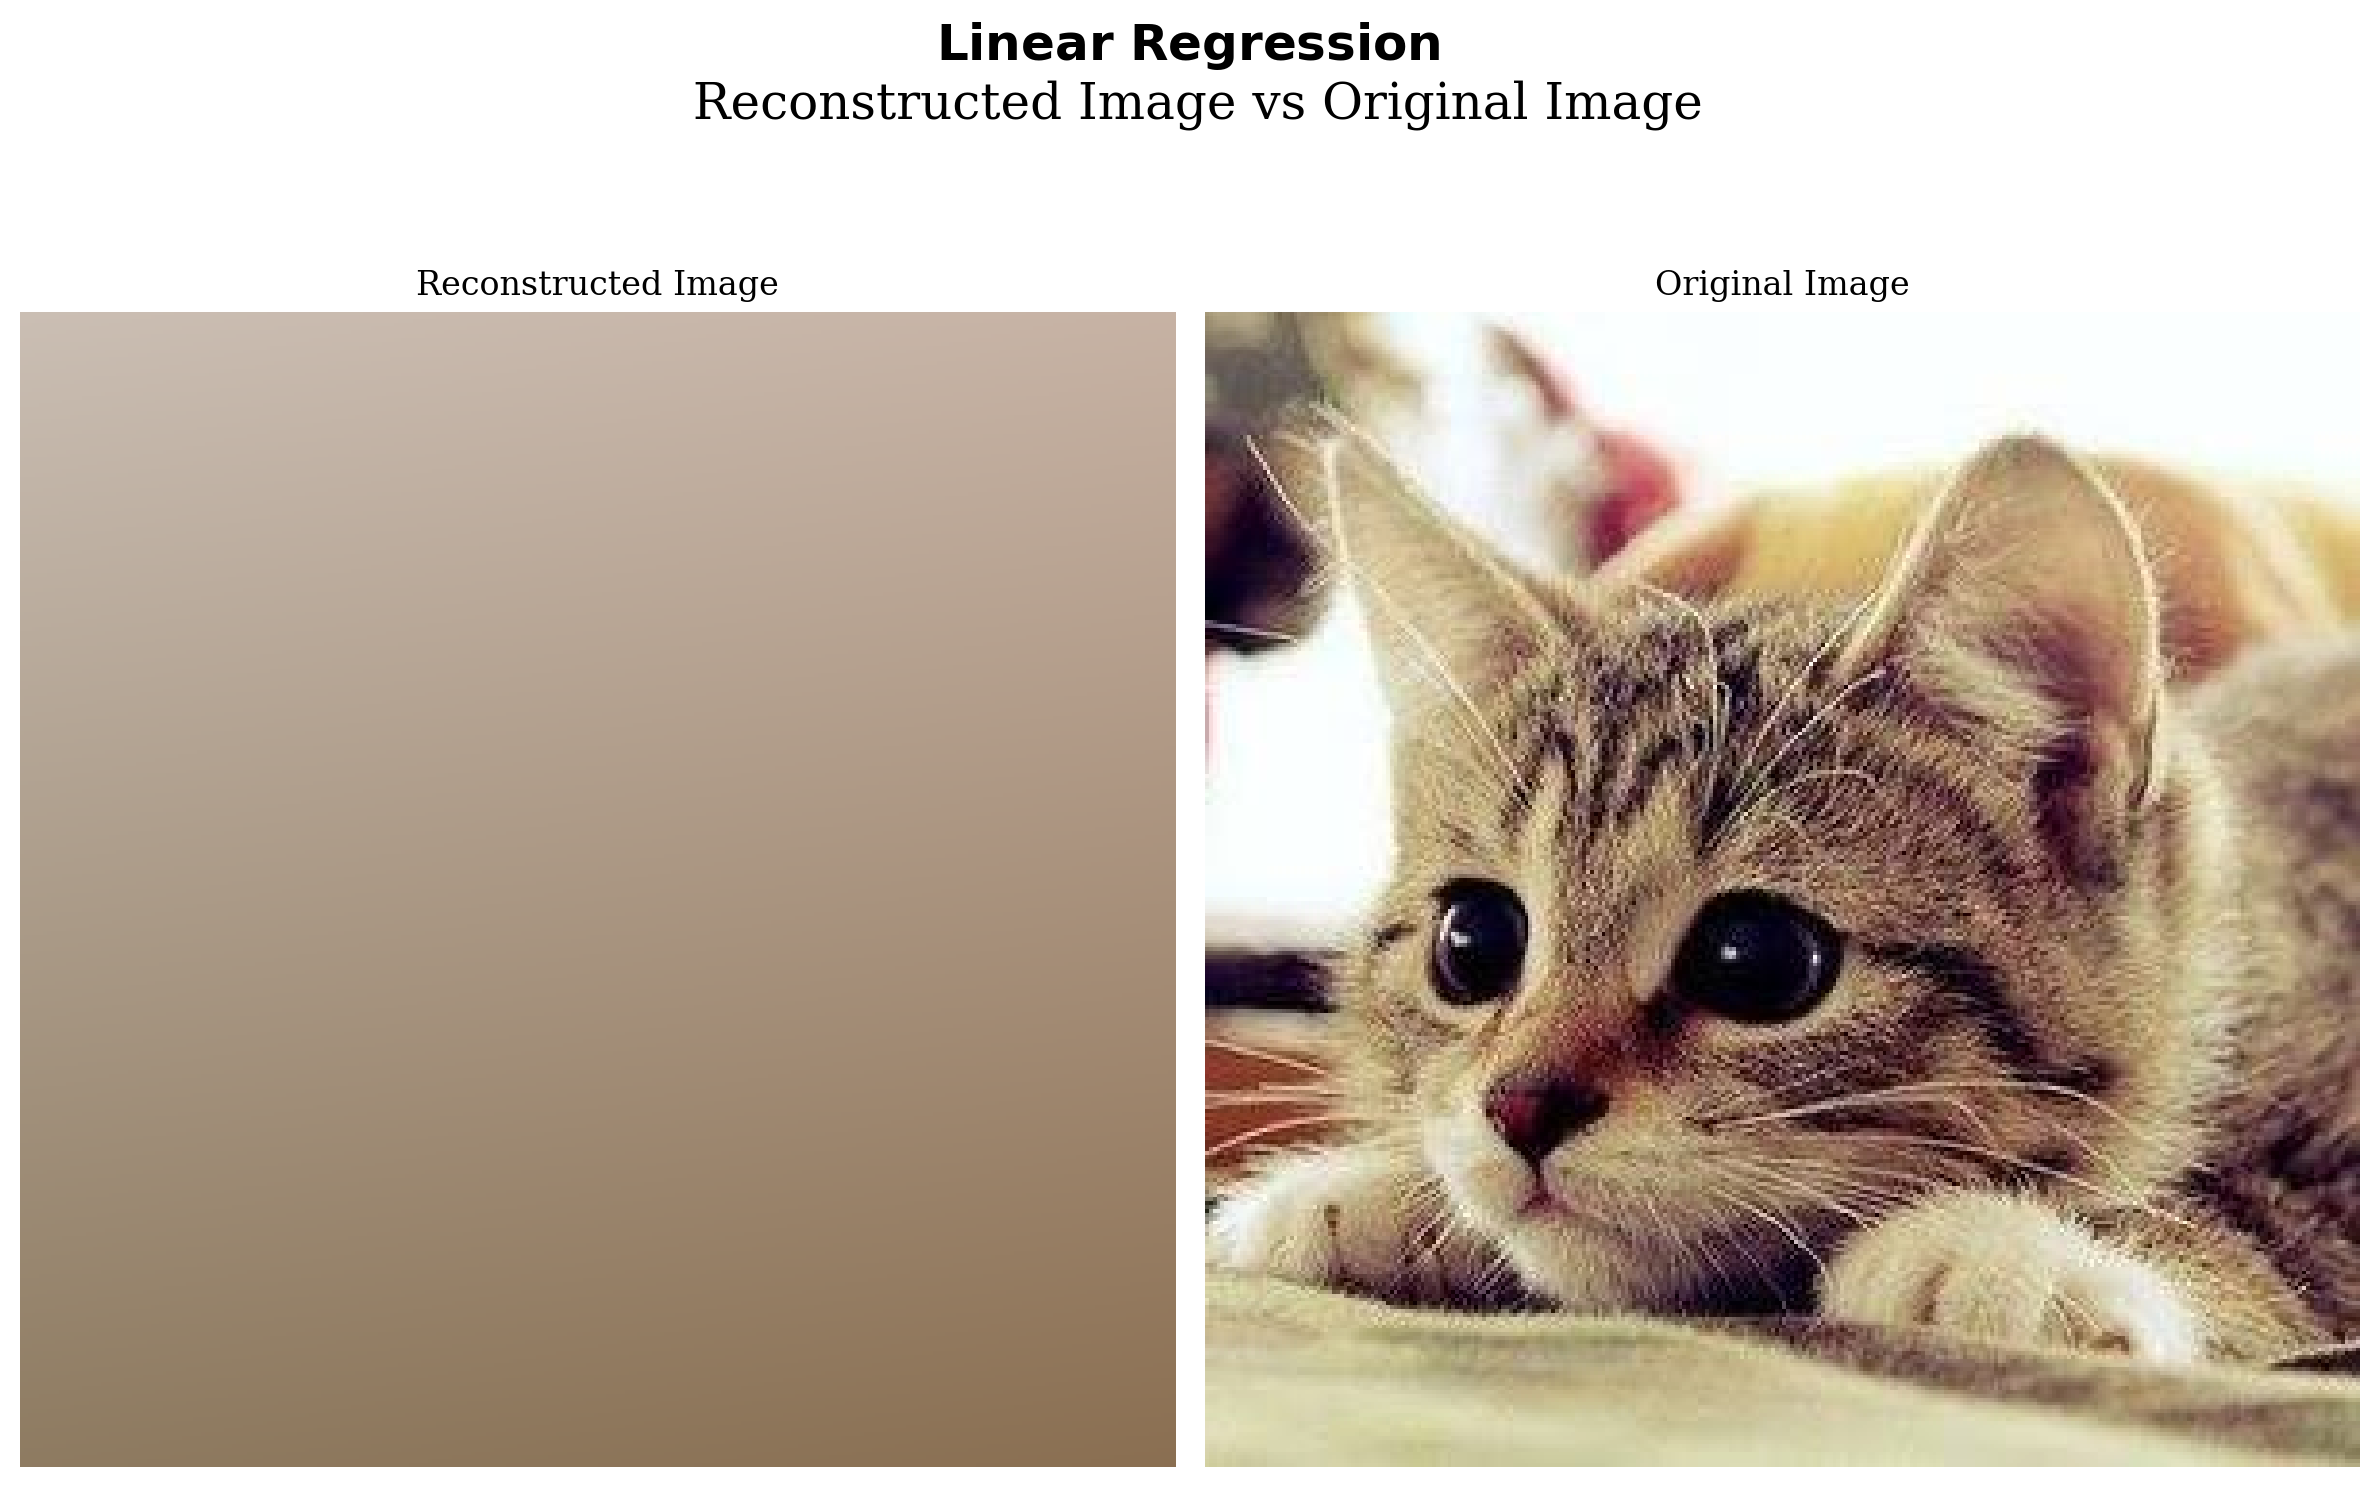

In [23]:
plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="$\\bf{Linear\ Regression}$ \n Reconstructed Image vs Original Image")

#### Random Fourier Features

In [24]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2)) #Creating random fourier features
    X = X.cpu().numpy() #Converting to numpy array
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [25]:
X_rff = create_rff_features(img_X_scaled, 15000, 0.008) #Creating random fourier features with 15000 features and sigma=0.008
X_rff.shape

torch.Size([90000, 15000])

In [26]:
net = LinearModel(X_rff.shape[1], 3) #Creating an instance of the LinearModel class with 15000 input features and 3 output features
net.to(device) #Moving the model to the device

mse=train(net, 0.05, X_rff, img_y, 501) #Training the model for 500 epochs with a learning rate of 0.05

Epoch 0 loss: 0.429666
Epoch 100 loss: 0.010156
Epoch 200 loss: 0.005944
Epoch 300 loss: 0.004705
Epoch 400 loss: 0.004196
Epoch 500 loss: 0.003993


In [27]:
print("Mean Squared Error: ",mse)
print("Peak Signal-to-Noise Ratio: ",psnr(float(crop.max()),mse))

Mean Squared Error:  0.003992810379713774
Peak Signal-to-Noise Ratio:  23.987213141481057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07244396..1.0884094].


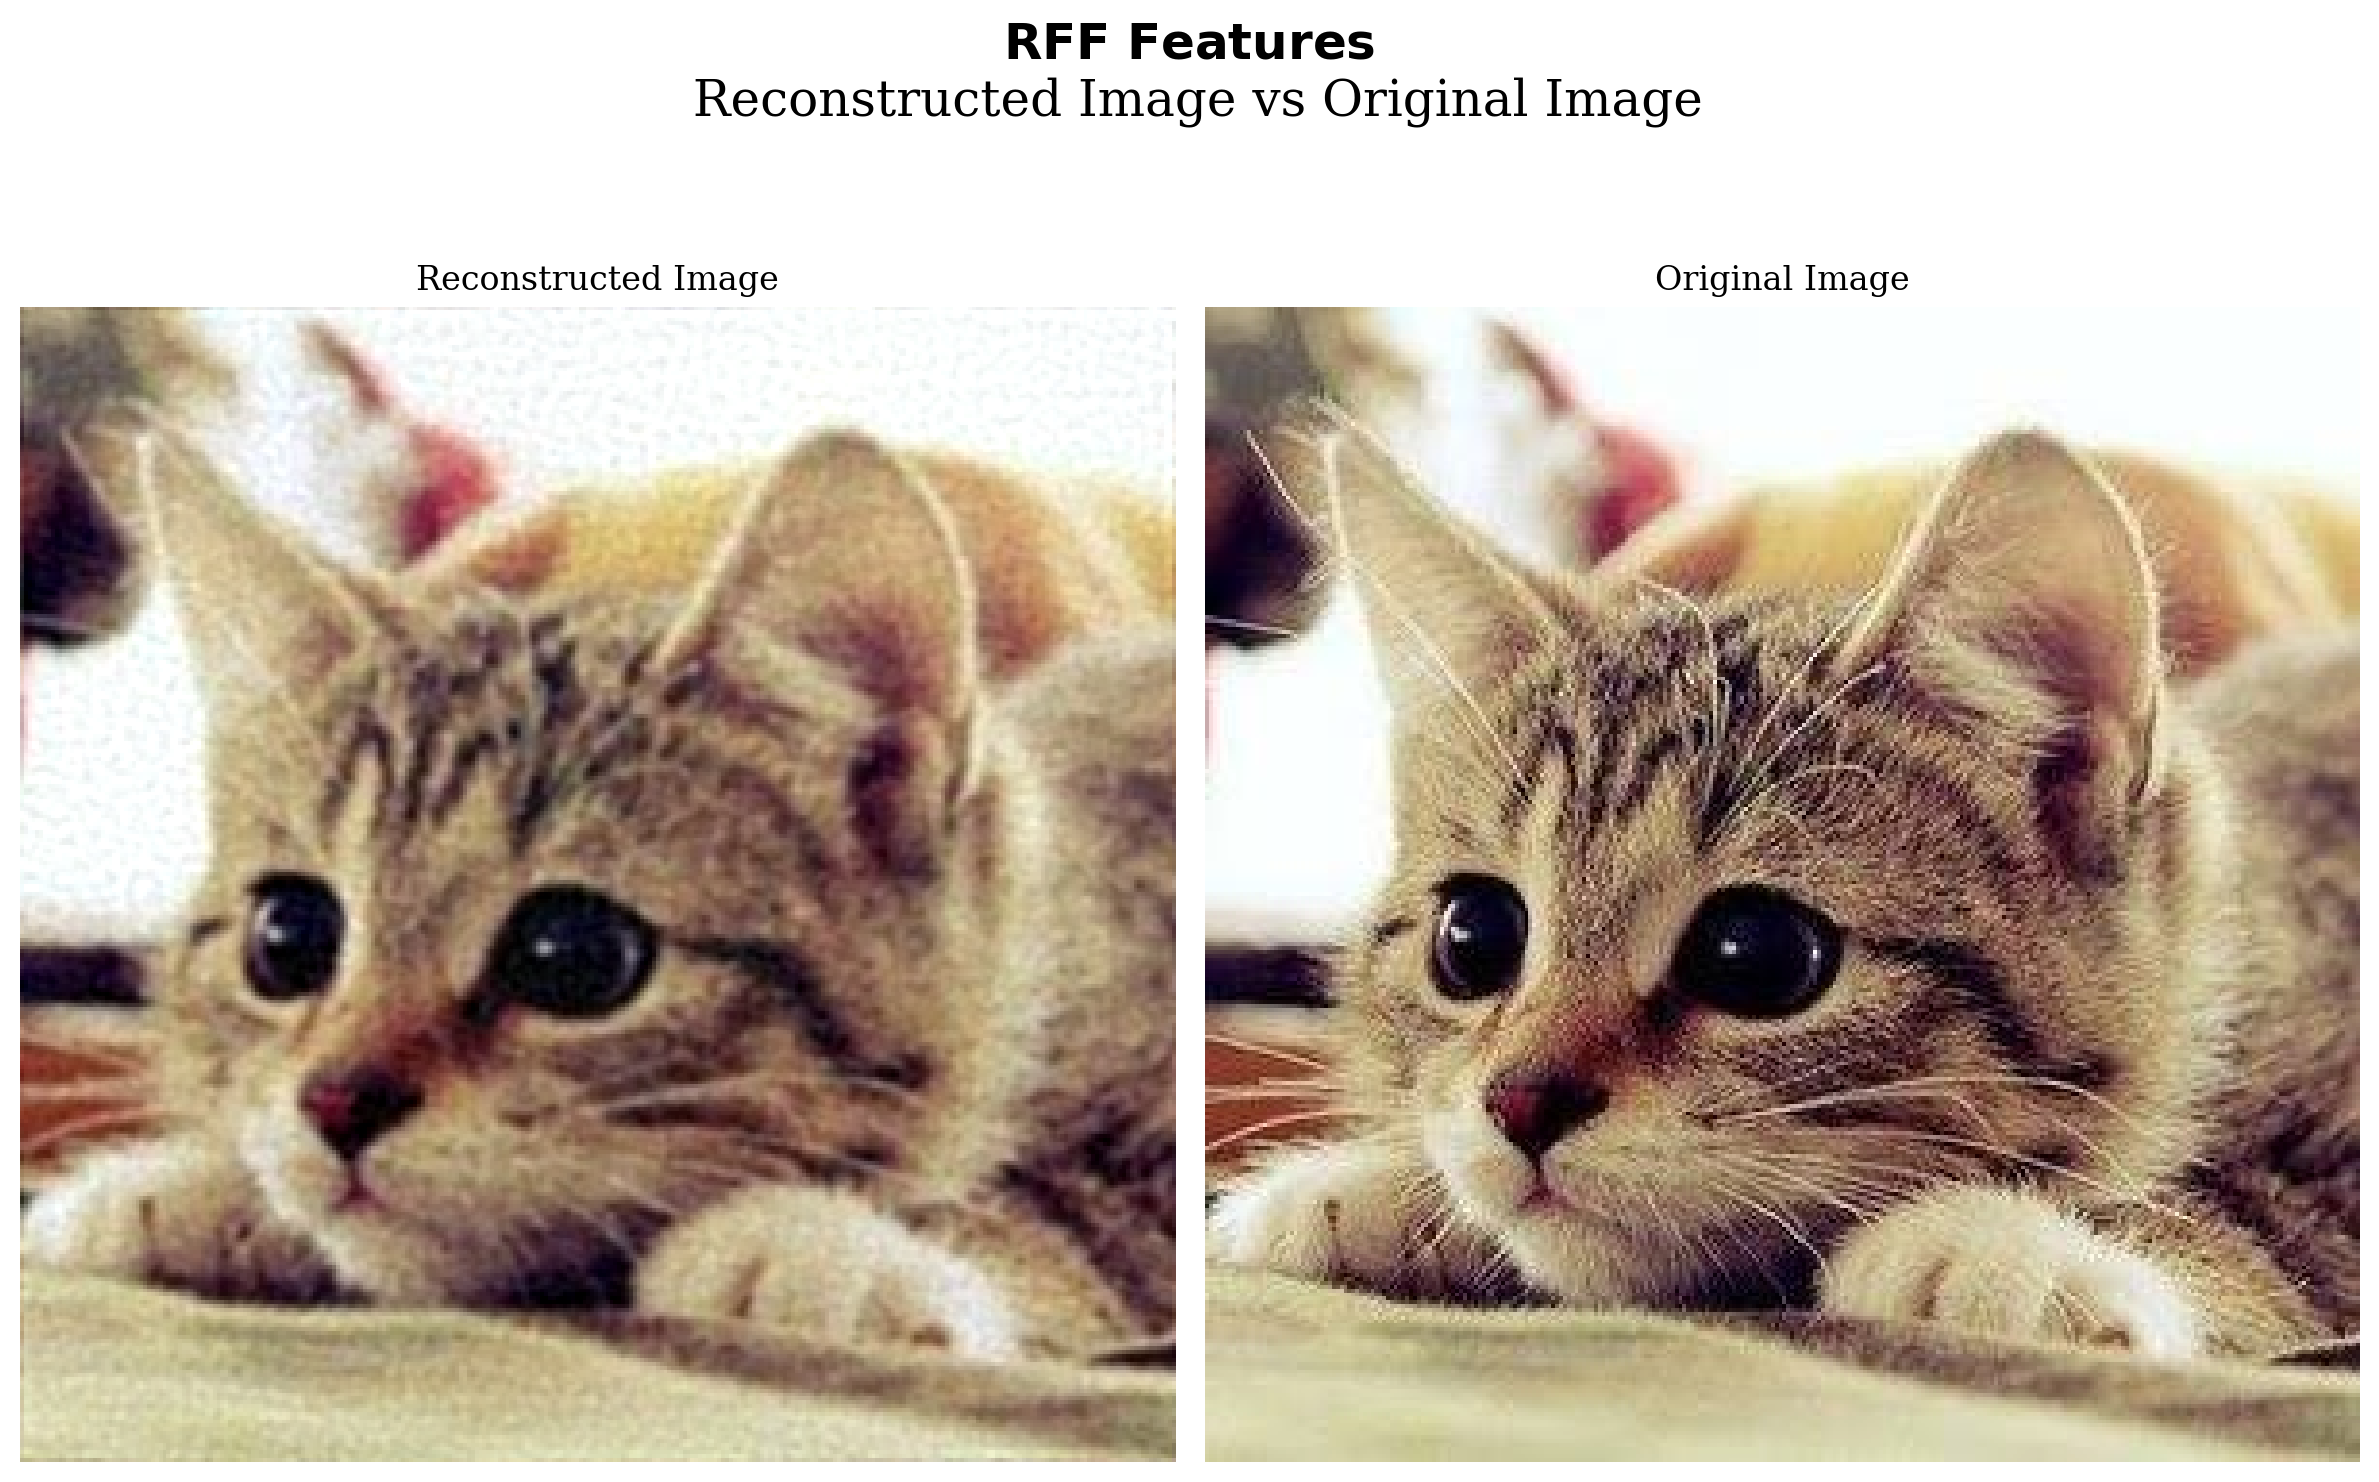

In [28]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="$\\bf{RFF\ Features}$ \n Reconstructed Image vs Original Image")

### Question 2

In [22]:
import soundfile 
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

# Setting device based on availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cpu


In [23]:
# Loading and playing audio
from IPython.display import Audio
Audio('Acoustic_Guitar.wav') 

In [24]:
# Loading audio using torchaudio
audio, sr = torchaudio.load('Acoustic_Guitar.wav')
print(audio.shape)

torch.Size([2, 466560])


In [25]:
audio = audio[0] #Selecting only the first channel (left)
tm = audio.shape[0] / sr   #Calculating the time of the audio
print(f"Audio length: {tm} seconds")

Audio length: 10.579591836734695 seconds


In [26]:
# Function to plot the audio waveform
def audio_plot(audio, sr, clr, tl): #Audio, Sampling Rate, Color, Title
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color=clr, alpha=0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1)) #Setting the xticks based on the sampling rate
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

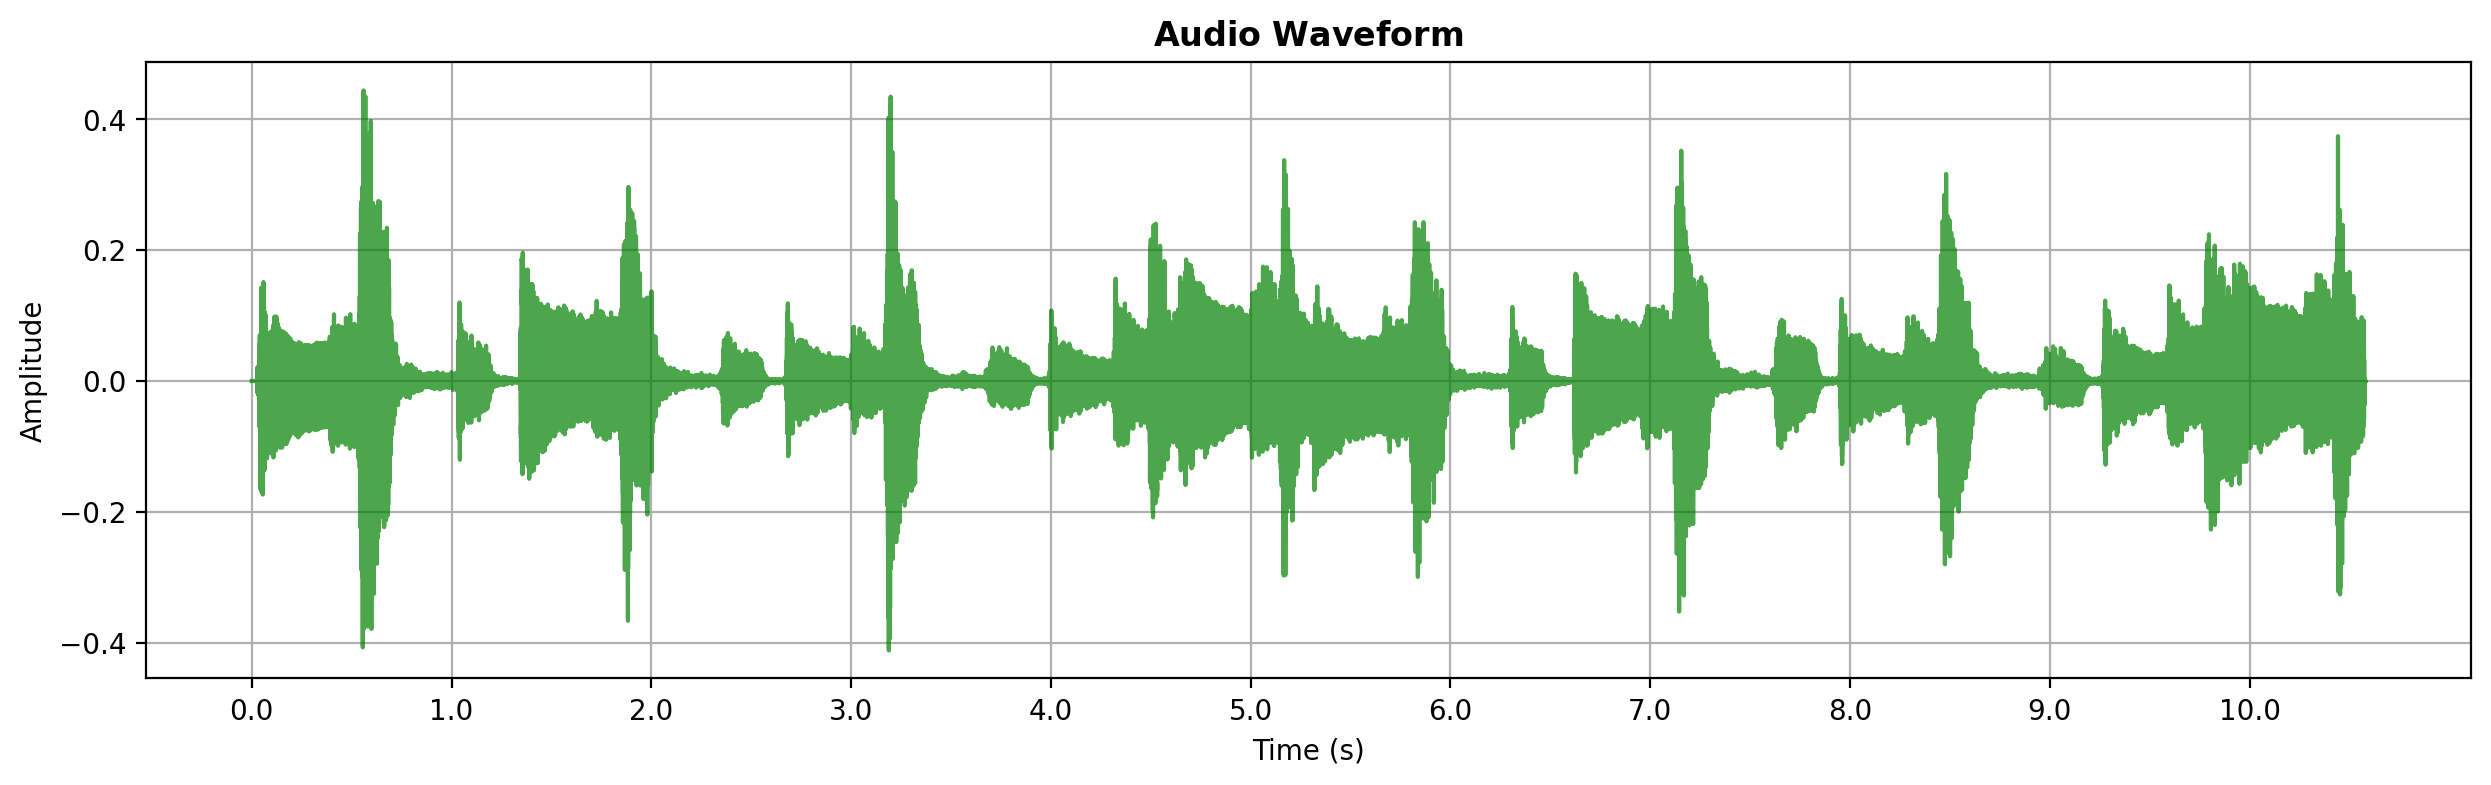

In [27]:
audio_plot(audio, sr, 'green', '$\\bf{Audio\ Waveform}$')

In [28]:
audio = audio[-5 * sr:] #Selecting the last 5 seconds of the audio
print(audio.shape)
print(audio)

torch.Size([220500])
tensor([0.0266, 0.0258, 0.0245,  ..., 0.0003, 0.0003, 0.0001])


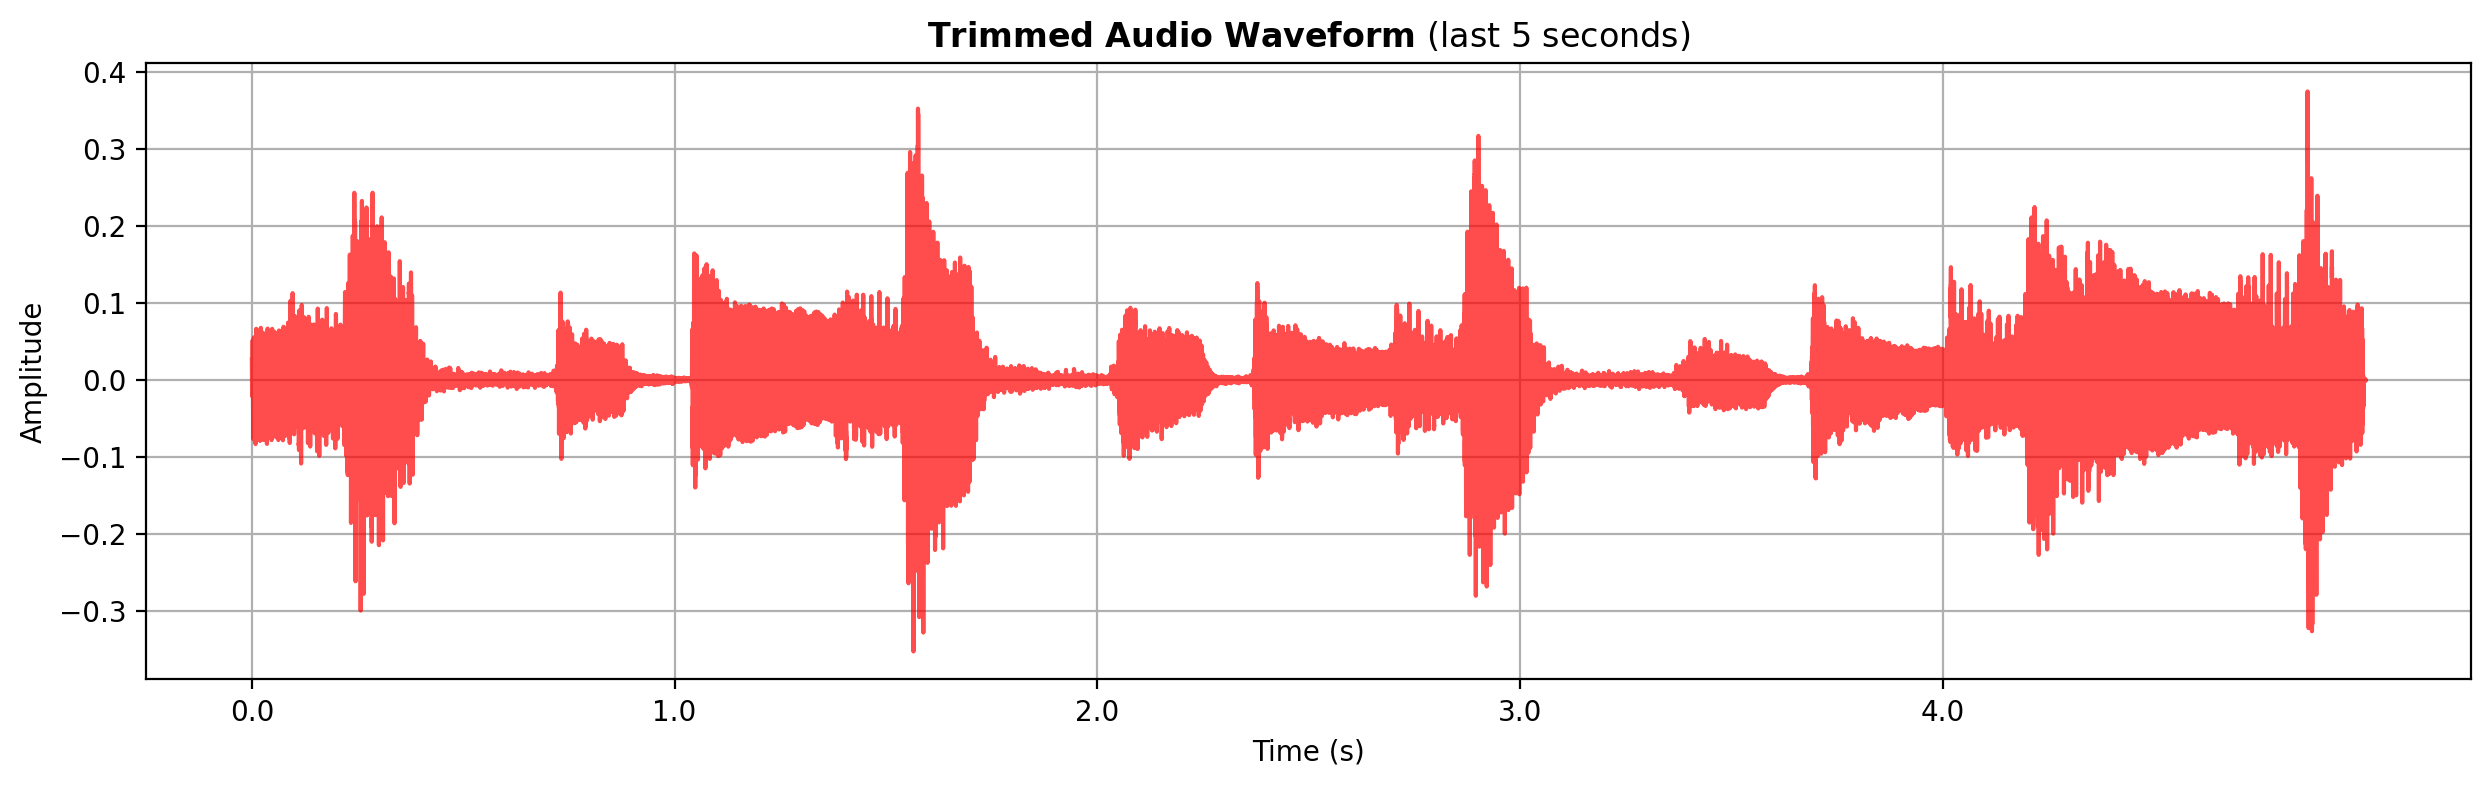

In [29]:
audio_plot(audio, sr, 'red', '$\\bf{Trimmed\ Audio\ Waveform}$ (last 5 seconds)')

In [30]:
X = torch.arange(0, len(audio)).unsqueeze(1).float() #Creating a tensor of shape (len(audio), 1) with values from 0 to len(audio)
X = X / X.max() * 200 - 100 #Scaling the tensor between -100 and 100 (for better training)
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [33]:
print("Last 5 seconds of audio")
Audio(audio, rate = sr)

Last 5 seconds of audio


In [34]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Setting a random state to the sampler for repoducibility (Here: 13)
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13) #Creating random fourier features
    X = X.cpu().numpy() #Converting to numpy array
    X = rff.fit_transform(X) #Fitting the data
    return torch.tensor(X, dtype = torch.float32)

In [57]:
num_features = 10000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma) #Creating random fourier features with 10000 features and sigma=0.008
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 10000])
tensor([[-0.0133, -0.0113,  0.0069,  ...,  0.0140, -0.0071, -0.0140],
        [-0.0129, -0.0105,  0.0068,  ...,  0.0138, -0.0093, -0.0141],
        [-0.0123, -0.0096,  0.0067,  ...,  0.0134, -0.0111, -0.0139],
        ...,
        [ 0.0136, -0.0029,  0.0009,  ...,  0.0121,  0.0140,  0.0004],
        [ 0.0133, -0.0017,  0.0008,  ...,  0.0114,  0.0135, -0.0019],
        [ 0.0129, -0.0005,  0.0008,  ...,  0.0106,  0.0124, -0.0042]])


In [58]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio) #Fitting the model using Linear Regression

pred_audio = model.predict(X_rff.numpy()) #Predicting the audio
print(pred_audio.shape)

(220500,)


In [59]:
#Importing joblib to save the model
import joblib 

joblib.dump(model, 'model.pkl') #Saving the model
model = joblib.load('model.pkl') #Loading the model

import soundfile as sf
sf.write('Acoustic_Guitar_Reconstructed.wav', pred_audio, sr) #Saving the predicted audio

In [60]:
print(pred_audio)
print(audio)

[ 0.00917731  0.01027213  0.01307212 ... -0.00075235  0.00376044
  0.00011359]
tensor([0.0266, 0.0258, 0.0245,  ..., 0.0003, 0.0003, 0.0001])


In [61]:
mse = np.mean((pred_audio - audio.numpy())**2) #Calculating the mean squared error
snr = 10 * np.log10(np.sum(audio.numpy()**2) / mse) #Calculating the signal-to-noise ratio
print("Mean Squared Error: ", mse)
print("Signal-to-Noise Ratio: ", snr)

Mean Squared Error:  0.00042102506
Signal-to-Noise Ratio:  60.082096


In [62]:
print("Predicted (Reconstructed) Audio")
Audio(pred_audio, rate = sr)

Predicted (Reconstructed) Audio


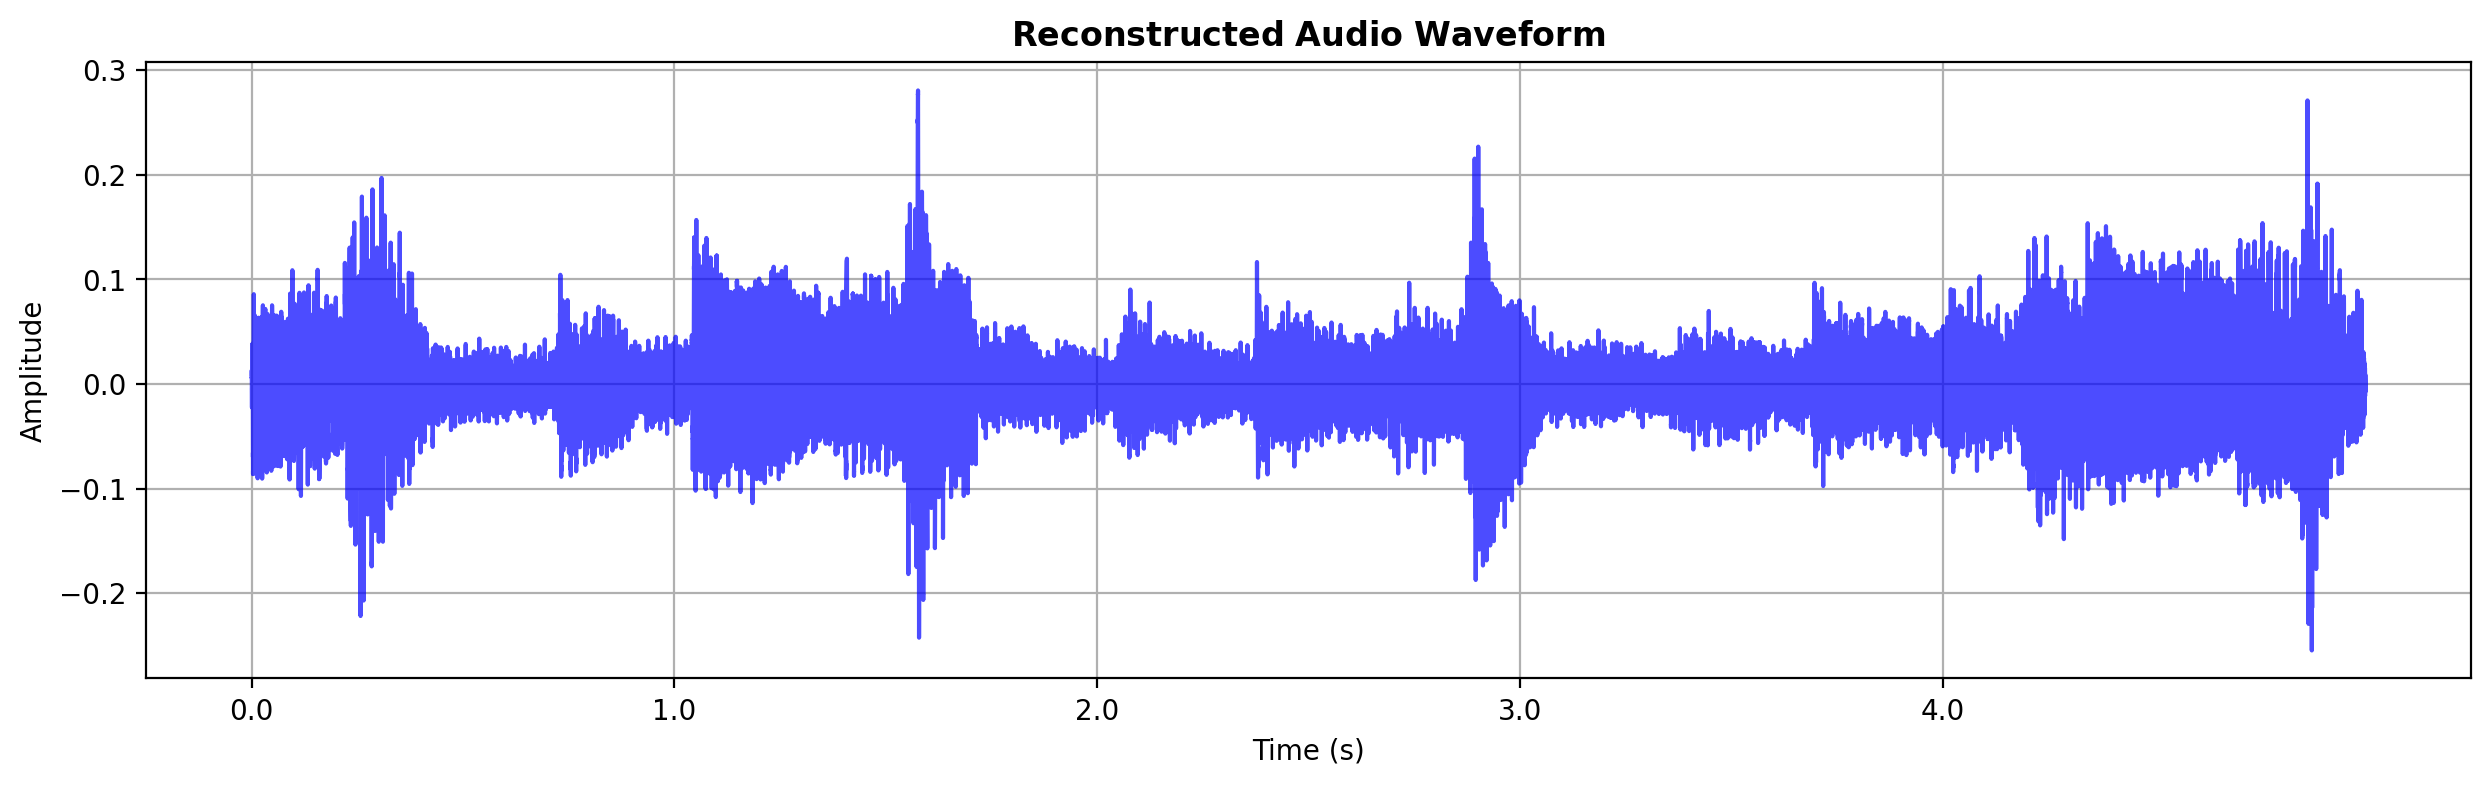

In [63]:
audio_plot(pred_audio, sr, 'blue', '$\\bf{Reconstructed\ Audio\ Waveform}$')

In [64]:
print("Original Audio")
Audio(audio, rate = sr)

Original Audio


In [65]:
print("Reconstructed Audio")
Audio(pred_audio, rate = sr)

Reconstructed Audio


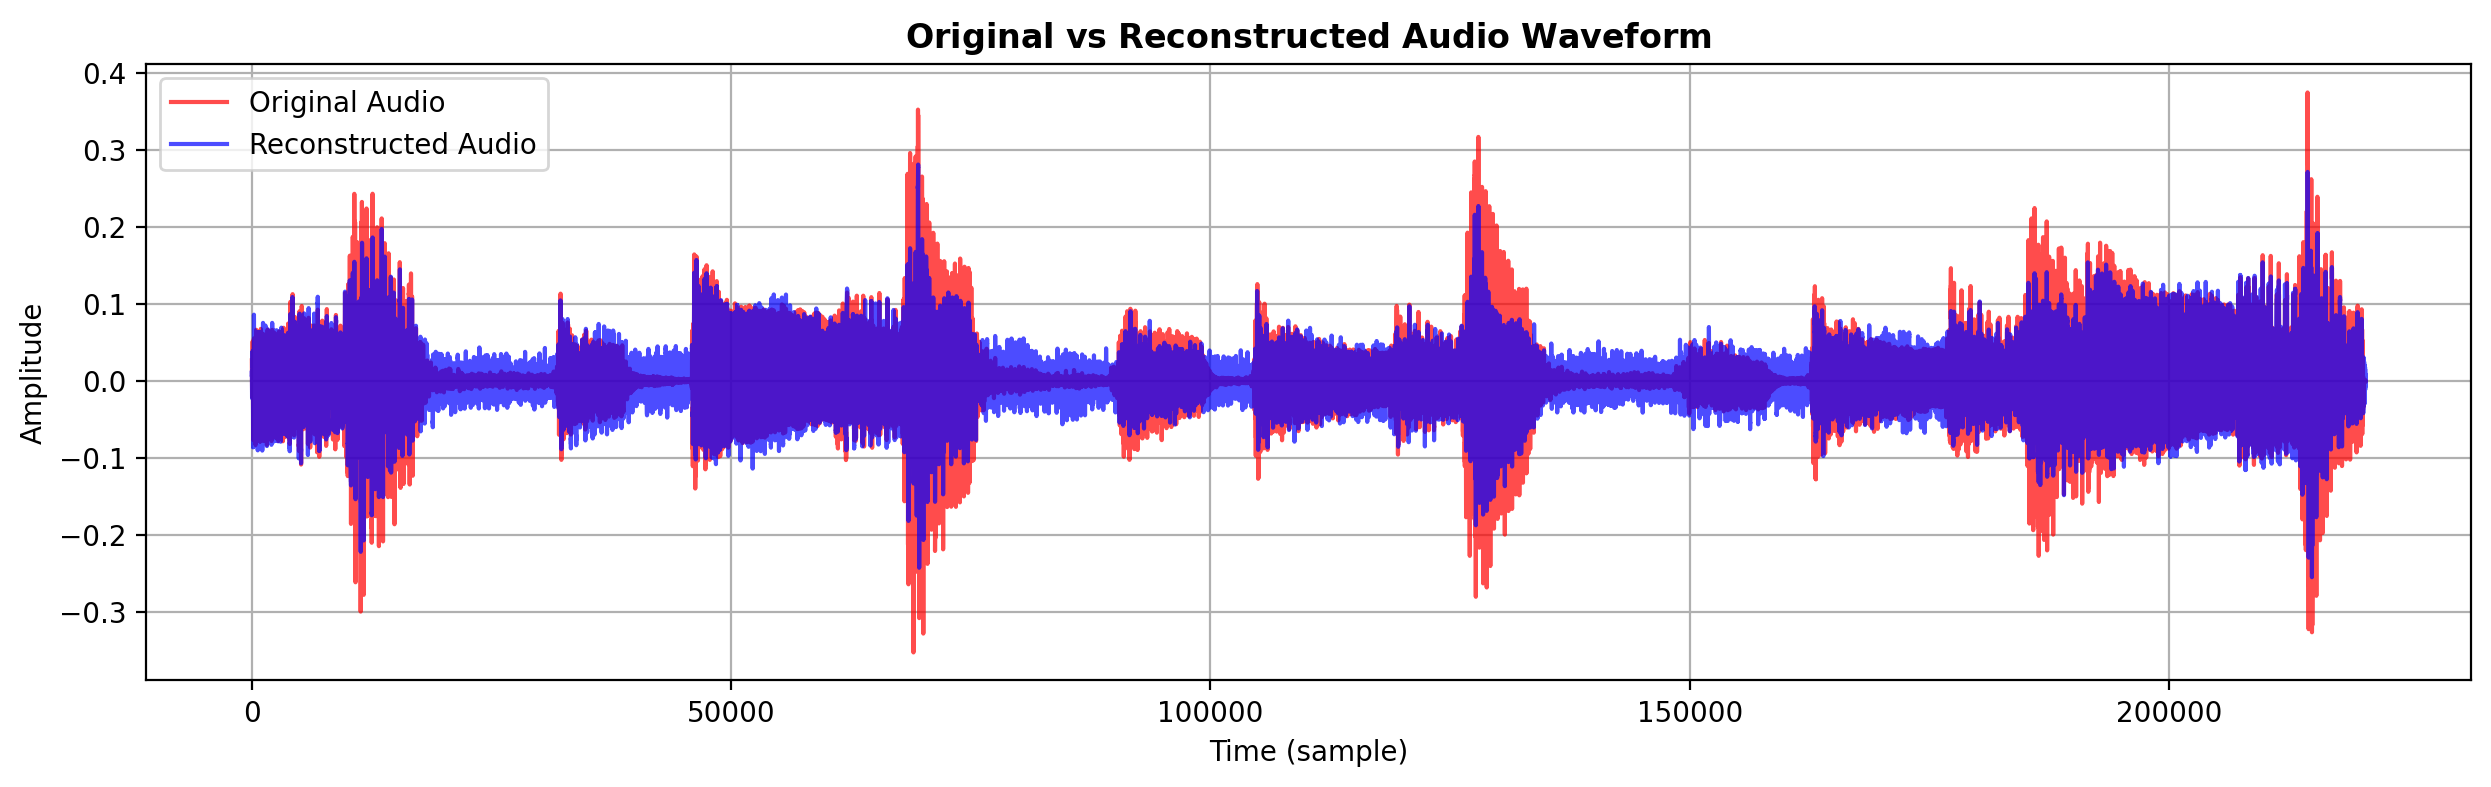

In [66]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'red', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'blue', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (sample)')
plt.ylabel('Amplitude')
plt.title('$\\bf{Original\ vs\ Reconstructed\ Audio\ Waveform}$')
plt.grid()
plt.legend()
plt.show()